## Basic Bayesian Optimization
In this tutorial we demonstrate the use of Xopt to preform Bayesian Optimization on a
 simple test problem.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    return {"f": np.sin(input_dict["x"])}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acqusition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt

evaluator = Evaluator(function=sin_function)
generator = UpperConfidenceBoundGenerator(vocs)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# print initial number of points to be generated
print(X.generator.options.n_initial)

# call X.step() to generate + evaluate initial points
X.step()

# inspect the gathered data
X.data

3


,x,f,xopt_runtime,xopt_error
1,3.693104,-0.523975,0.000010,False
2,0.285836,0.281960,0.000002,False
3,0.722819,0.661501,0.000001,False


## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

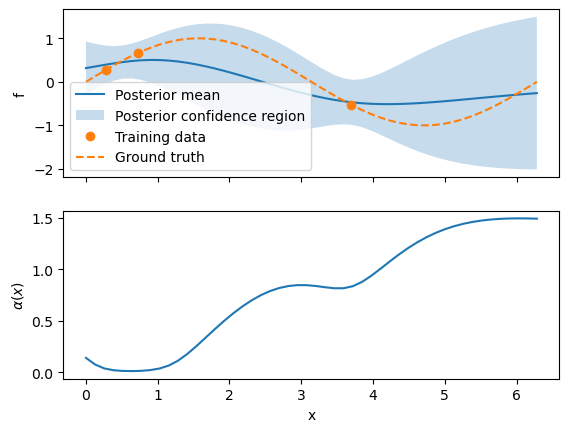

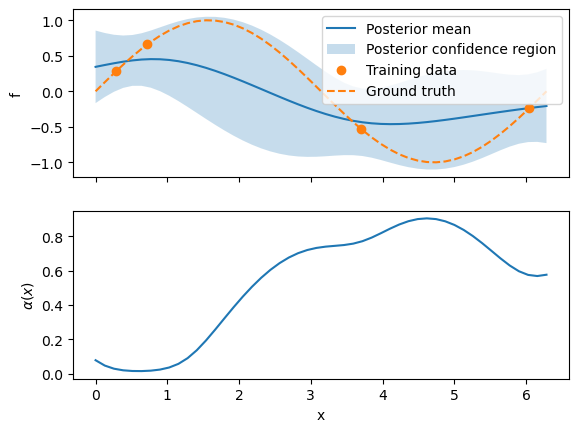

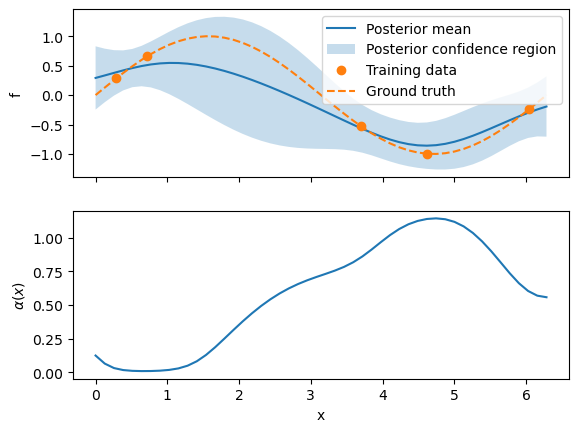

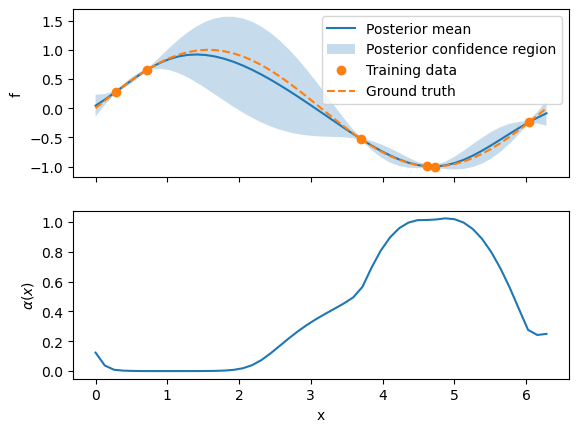

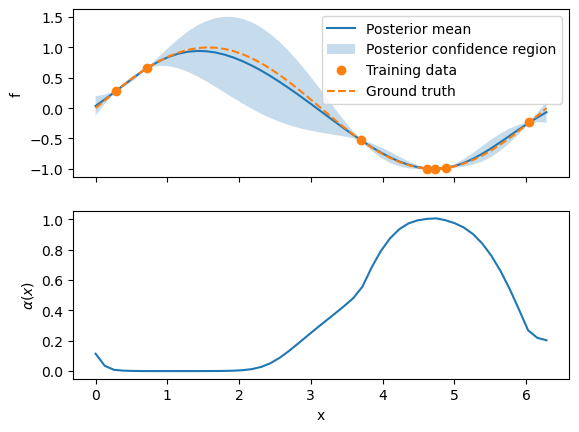

In [5]:
import torch
import matplotlib.pyplot as plt
n_steps = 3

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(),50).double()

for i in range(5):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1,1,1))

    # get mean function and confidence regions
    mean = posterior.mean
    l,u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig,ax = plt.subplots(2,1,sharex="all")

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, l, u,alpha=0.25, label="Posterior confidence region")

    # add data to model plot
    ax[0].plot(X.data["x"],X.data["f"],"C1o", label="Training data")

    # plot true function
    true_f = sin_function({"x": test_x})["f"]
    ax[0].plot(test_x, true_f,'--', label="Ground truth")

    # add legend
    ax[0].legend()

    # plot acquisition function
    ax[1].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("f")
    ax[1].set_ylabel(r"$\alpha(x)$")
    ax[1].set_xlabel("x")

    # do the optimization step
    X.step()


In [6]:
# access the collected data
X.data

,x,f,xopt_runtime,xopt_error
1,3.693104,-0.523975,0.000010,False
2,0.285836,0.281960,0.000002,False
3,0.722819,0.661501,0.000001,False
4,6.045030,-0.235911,0.000009,False
5,4.616683,-0.995424,0.000009,False
6,4.735570,-0.999731,0.000009,False
7,4.887444,-0.984717,0.000010,False
8,4.721819,-0.999956,0.000009,False


## Getting the optimization result
To get the ideal point (without evaluating the point) we ask the generator to
generate a new point.

In [7]:
X.generator.generate(1)

,x
0,4.720102


## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [8]:
X.generator.options.dict()

{'optim': {'num_restarts': 5,
  'raw_samples': 20,
  'sequential': True,
  'use_nearby_initial_points': False,
  'max_travel_distances': None},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'beta': 2.0},
 'model': {'function': <function xopt.generators.bayesian.models.standard.create_standard_model(data: pandas.core.frame.DataFrame, vocs: xopt.vocs.VOCS, tkwargs: dict, use_conservative_prior_lengthscale: bool = False, use_conservative_prior_mean: bool = False, use_low_noise_prior: bool = False)>,
  'kwargs': {'use_conservative_prior_lengthscale': False,
   'use_conservative_prior_mean': False,
   'use_low_noise_prior': False}},
 'n_initial': 3,
 'use_cuda': False}

In [9]:
# example: add a Gamma(1.0,10.0) prior to the noise hyperparameter to reduce model noise
# (good for optimizing noise-free simulations)
X.generator.options.model.kwargs.use_low_noise_prior = True